Basin hopping Global Optimisation
=================================

Knowledge 
- https://machinelearningmastery.com/basin-hopping-optimization-in-python/

Random note
-----------
Take background as negative excursion

1) find background and modulation settings at x contrast
2) Use background and modulation settings as upper and lower bounds to find settings y%, where y% < x%
3) Use background and modulation settings at Y% as starting point for next Y%

Basic example with rosenbrock
-----------------------------

In [1]:
from scipy.optimize import rosen, basinhopping
bounds = [(0,2), (0, 2)]
result = basinhopping(rosen, bounds)
result.x, result.fun


(array([0.99999934, 0.99999857, 0.99999733, 0.99999477]),
 1.586576705885505e-11)

In [2]:
import sys
sys.path.insert(0, '../')
import random

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.optimize import basinhopping, Bounds
from scipy.interpolate import interp1d

from silentsub.device import StimulationDevice
from silentsub.plotting import stim_plot
from silentsub.CIE import get_CIES026

sns.set_context('notebook')
sns.set_style('whitegrid')


Load the data with `StimulationDevice`
--------------------------------------

In [3]:
spds = pd.read_csv('../data/S2_corrected_oo_spectra.csv', index_col=['led','intensity'])
spds.index.rename(['Primary', 'Setting'], inplace=True)
spds.columns = pd.Int64Index(spds.columns.astype(int))

# list of colors for the primaries
colors = ['blueviolet', 'royalblue', 'darkblue', 'blue', 'cyan', 
          'green', 'lime', 'orange', 'red', 'darkred']

# instantiate the class
device = StimulationDevice(
    resolutions=[4095]*10,
    colors=colors,
    spds=spds,
    spd_binwidth=1)

Define optimisation problem
---------------------------

This is the 'basic' optimisation where we aim to maximise melanopic contrast whilst keeping cone contrast at zero.

In [21]:
class OptimisationProblem:
    def __init__(self, aopic):
        self.aopic = aopic

    def smlri_calculator(self, weights):
        '''Calculates a-opic irradiance for the given weights.
        The first 10 values in weights define the background
        spectrum and the second 10 values define the modulation'''
        background = weights[0:10]
        modulation = weights[10:20]
        bg_smlri = 0
        mod_smlri = 0
        for led in range(10):
            x = self.aopic.loc[led].index / 4095
            y = self.aopic.loc[led]
            f = interp1d(x, y, axis=0, fill_value='extrapolate')
            bg_smlri += f(background[led])
            mod_smlri += f(modulation[led])
        return (pd.Series(bg_smlri, index=self.aopic.columns, name='Background'),
                pd.Series(mod_smlri, index=self.aopic.columns, name='Modulation'))

    def objective_function(self, weights, target_contrast=2.):
        '''Calculates negative melanopsin contrast for background
        and modulation spectra. We want to minimise this.'''
        bg_smlri, mod_smlri = self.smlri_calculator(weights)
        contrast = (mod_smlri.I-bg_smlri.I) / bg_smlri.I
        if target_contrast:
            return pow(contrast-target_contrast, 2)
        else:
            return -contrast
        
    def cone_contrast_constraint_function(self, weights):
        '''Calculates S-, M-, and L-opic contrast for background
        and modulation spectra. We want to this to be zero'''
        bg_smlri, mod_smlri = self.smlri_calculator(weights)
        contrast = np.array([(mod_smlri.S-bg_smlri.S) / bg_smlri.S,
                             (mod_smlri.M-bg_smlri.M) / bg_smlri.M,
                             (mod_smlri.L-bg_smlri.L) / bg_smlri.L])
        return contrast

    def weights_to_settings(self, weights):
        '''Turns weights to 12-bit STLAB settings.'''
        return ([int(val*4095) for val in weights[0:10]],
                [int(val*4095) for val in weights[10:20]])

Do optimisation
---------------

basinhopping step 0: f 0.439765
Melanopsin contrast at minimum: 0.4397654026864499, accepted True


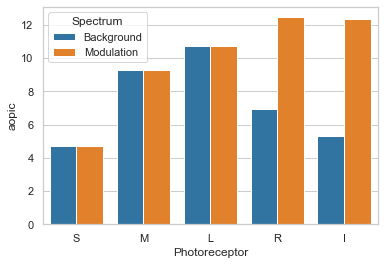

[  9.37344436e-01   5.60898993e-15   2.11737705e-16   3.21649383e-16
   1.45386470e-16   1.03717723e-02   5.86459210e-01   1.26310203e-02
   1.78727329e-16   9.39604307e-16   4.04948321e-15   2.90028209e-15
   3.07411060e-01   3.20846874e-01   9.95821409e-01   1.06331279e-03
   1.75357115e-15   1.28375731e-01   9.36521021e-01   1.00000000e+00]
basinhopping step 1: f 0.24348 trial_f 0.24348 accepted 1  lowest_f 0.24348
found new global minimum on step 1 with function value 0.24348
Melanopsin contrast at minimum: 0.2434799004095865, accepted True


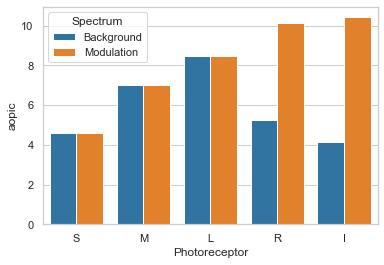

[  9.04135025e-01   4.19335217e-16   2.36056100e-18   5.44163445e-17
   2.69683497e-16   1.59680133e-02   3.94658671e-01   1.21245566e-01
   1.93447778e-16   3.93858363e-16   6.81962108e-06   2.21036514e-17
   1.50285493e-03   7.49130531e-01   5.86623992e-01   2.58921738e-03
   1.30330947e-17   6.34939969e-02   9.83814388e-01   1.00000000e+00]
basinhopping step 2: f 5.53413e-05 trial_f 5.53413e-05 accepted 1  lowest_f 5.53413e-05
found new global minimum on step 2 with function value 5.53413e-05
Melanopsin contrast at minimum: 5.534133056555913e-05, accepted True


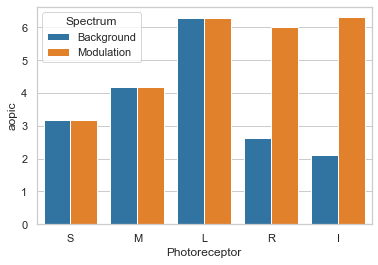

[  6.30760700e-01   1.21861217e-16   3.82499268e-18   8.02805245e-07
   4.39167690e-17   1.25008902e-05   1.25534419e-01   2.61393029e-01
   0.00000000e+00   0.00000000e+00   1.25210948e-05   7.68767103e-17
   7.92216943e-02   3.88439570e-01   2.53968253e-01   0.00000000e+00
   1.21672009e-02   1.06972190e-02   9.86293765e-01   1.00000000e+00]
basinhopping step 3: f 0.000947781 trial_f 0.000947781 accepted 1  lowest_f 5.53413e-05
Melanopsin contrast at minimum: 0.0009477810102079371, accepted True


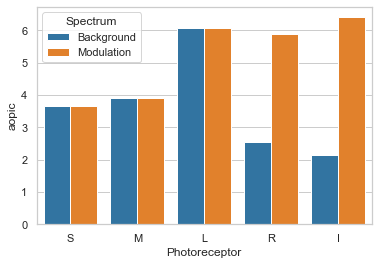

[  7.46022631e-01   0.00000000e+00   9.24093758e-19   1.10500140e-16
   3.83911720e-17   5.18155311e-17   1.09286461e-01   2.59656046e-01
   5.28329754e-02   4.41221397e-17   1.66409327e-02   1.66038117e-15
   3.14686902e-17   6.34864905e-01   1.53317663e-01   3.72361862e-17
   3.27880066e-18   4.36698489e-02   1.00000000e+00   1.00000000e+00]
basinhopping step 4: f 0.347011 trial_f 0.347011 accepted 1  lowest_f 5.53413e-05
Melanopsin contrast at minimum: 0.34701050108852705, accepted True


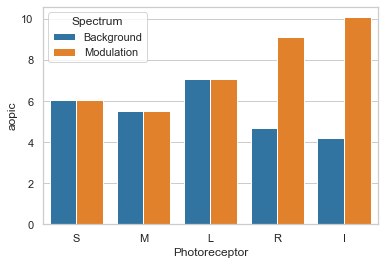

[  1.00000000e+00   1.42855596e-01   1.44559018e-16   2.23541017e-18
   9.44124182e-18   1.58836598e-02   2.53946011e-01   1.60135636e-01
   1.23953177e-17   1.26984108e-01   7.16997375e-18   5.02100542e-18
   1.62407915e-01   8.98286720e-01   2.31692208e-01   6.42894104e-19
   7.04011366e-18   1.46689635e-02   9.84177857e-01   1.00000000e+00]
basinhopping step 5: f 0.518994 trial_f 0.518994 accepted 1  lowest_f 5.53413e-05
Melanopsin contrast at minimum: 0.5189941629162905, accepted True


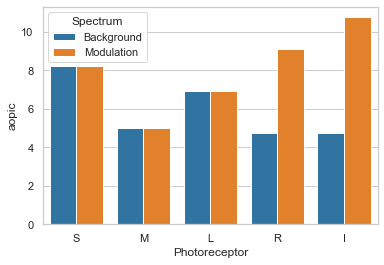

[  9.98627971e-01   4.60317456e-01   0.00000000e+00   4.24512189e-14
   2.22504175e-12   1.58756724e-02   1.20191386e-01   2.74178273e-01
   2.71337237e-13   1.12711192e-11   2.06866112e-10   1.47213791e-12
   6.98524580e-01   7.92502493e-01   1.74812399e-13   1.71110888e-04
   2.32898630e-10   9.23324086e-02   9.23394028e-01   1.00000000e+00]
basinhopping step 6: f 2.9335e-12 trial_f 2.9335e-12 accepted 1  lowest_f 2.9335e-12
found new global minimum on step 6 with function value 2.9335e-12
Melanopsin contrast at minimum: 2.9335036543662402e-12, accepted True


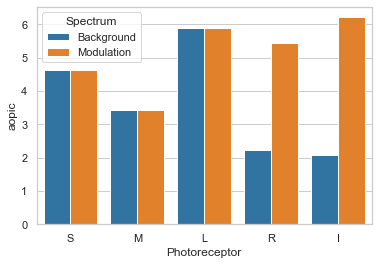

[  9.99663527e-01   4.45538268e-04   0.00000000e+00   1.93390201e-20
   3.02418898e-19   1.56260028e-02   1.58620756e-02   3.45218384e-01
   3.76321684e-20   0.00000000e+00   0.00000000e+00   2.56674506e-03
   6.14026015e-01   1.48087509e-01   5.99099388e-02   4.16620342e-04
   1.05269991e-04   6.98825090e-02   9.51471434e-01   1.00000000e+00]
basinhopping step 7: f 0.205979 trial_f 0.205979 accepted 1  lowest_f 2.9335e-12
Melanopsin contrast at minimum: 0.20597930610296059, accepted True


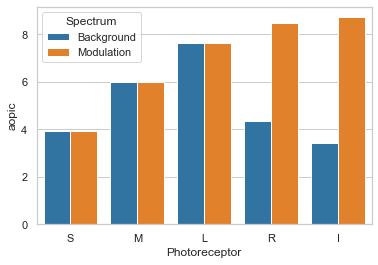

[  7.92767244e-01   3.90592403e-14   0.00000000e+00   0.00000000e+00
   6.35448085e-14   1.60844405e-02   3.05706126e-01   1.64084066e-01
   2.73125854e-14   1.01711418e-13   0.00000000e+00   9.34193531e-16
   9.36967024e-02   5.05197932e-01   4.72192502e-01   0.00000000e+00
   6.90642681e-15   8.78326438e-02   7.61903255e-01   1.00000000e+00]
basinhopping step 8: f 0.341869 trial_f 0.341869 accepted 1  lowest_f 2.9335e-12
Melanopsin contrast at minimum: 0.3418686032915206, accepted True


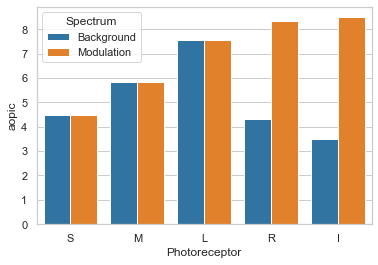

[  8.62664509e-01   2.22361444e-02   1.89830793e-12   8.37383043e-13
   9.23848428e-14   2.55732862e-21   2.81760897e-01   1.82450160e-01
   1.85156943e-20   4.60924333e-12   1.11563547e-11   1.89117038e-01
   7.84210924e-02   2.79816813e-01   5.33794716e-01   2.35750386e-20
   6.44148155e-14   4.75903607e-02   9.84126977e-01   1.00000000e+00]
basinhopping step 9: f 0.788816 trial_f 0.788816 accepted 1  lowest_f 2.9335e-12
Melanopsin contrast at minimum: 0.7888163410820183, accepted True


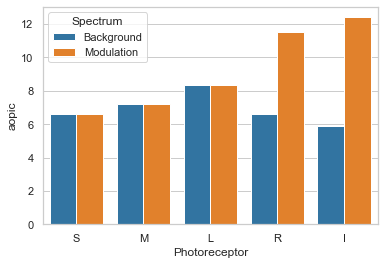

[  2.33462712e-01   6.82539910e-01   1.65949336e-16   5.34130144e-18
   5.94557116e-18   1.65820584e-02   3.80899498e-01   1.06725201e-01
   4.62184675e-20   7.70065630e-20   2.40873435e-16   2.94861383e-17
   1.60375100e-01   9.68554697e-01   4.92061537e-01   1.31698861e-17
   2.63895619e-16   5.15753383e-18   9.84126979e-01   1.00000000e+00]
basinhopping step 10: f 0.268382 trial_f 0.268382 accepted 1  lowest_f 2.9335e-12
Melanopsin contrast at minimum: 0.2683819912068465, accepted True


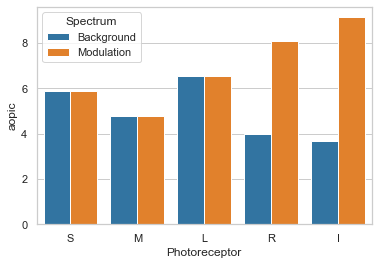

[  8.07072257e-01   2.22026146e-01   4.11845960e-16   2.27943552e-16
   3.94458894e-16   1.58730521e-02   1.52985499e-01   2.33096155e-01
   2.09678332e-16   8.70600100e-15   1.31670288e-16   1.97230628e-16
   1.63987156e-01   8.91170723e-01   1.26976165e-01   4.03429161e-15
   3.36210855e-15   1.58272029e-02   9.81560880e-01   1.00000000e+00]
basinhopping step 11: f 0.238089 trial_f 0.238089 accepted 1  lowest_f 2.9335e-12
Melanopsin contrast at minimum: 0.23808854873473365, accepted True


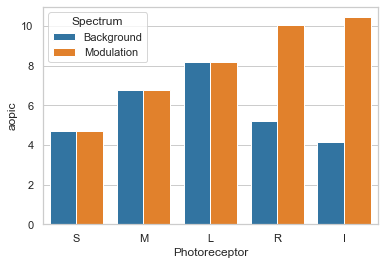

[  9.58645418e-01   1.30372688e-14   1.59167797e-15   6.15050156e-15
   6.11821754e-17   4.25683066e-15   3.89584023e-01   1.08880208e-01
   2.81652980e-15   2.47645694e-15   6.15374831e-15   7.11969018e-14
   6.15644951e-15   7.83917308e-01   5.64932741e-01   2.33328192e-17
   8.89682850e-16   4.76180997e-02   9.51724408e-01   1.00000000e+00]
basinhopping step 12: f 0.247332 trial_f 0.247332 accepted 1  lowest_f 2.9335e-12
Melanopsin contrast at minimum: 0.24733183857601052, accepted True


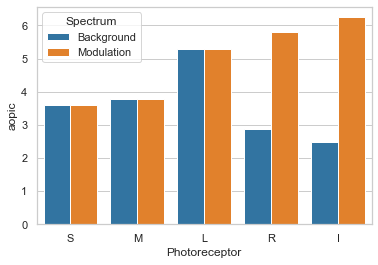

[  5.07911273e-01   1.11087642e-01   1.07885712e-15   4.59753872e-16
   2.89757209e-16   3.78807146e-03   1.42418473e-01   1.93697977e-01
   5.82655350e-03   5.34741792e-02   2.71632159e-18   5.34169240e-16
   3.49206033e-01   2.11209598e-01   2.07033375e-01   1.34143550e-17
   1.64736517e-18   1.24566082e-03   5.71422320e-01   9.36474336e-01]
basinhopping step 13: f 0.247332 trial_f 0.796729 accepted 0  lowest_f 2.9335e-12
Melanopsin contrast at minimum: 0.796729109085386, accepted False


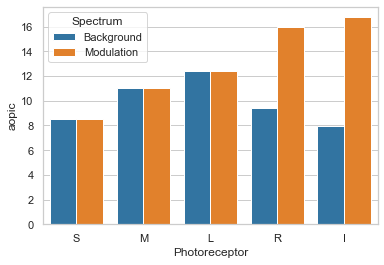

[  9.12791297e-01   4.89356633e-01   2.52946806e-18   1.39131946e-18
   1.17883509e-17   4.76250857e-02   6.50662317e-01   9.78186417e-04
   1.77229420e-18   6.64267345e-19   9.32729506e-17   4.66591779e-16
   4.58870248e-01   9.58600333e-01   8.41329289e-01   9.00846149e-04
   2.24910565e-17   1.77350371e-01   9.87809999e-01   1.00000000e+00]
basinhopping step 14: f 0.00169113 trial_f 0.00169113 accepted 1  lowest_f 2.9335e-12
Melanopsin contrast at minimum: 0.0016911329008300355, accepted True


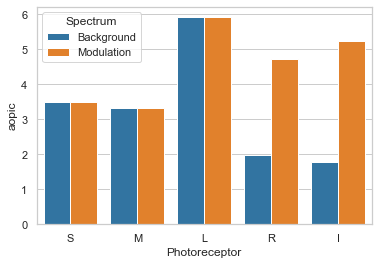

[  5.36738984e-01   7.61957110e-02   0.00000000e+00   8.42612315e-17
   0.00000000e+00   1.53933478e-02   3.53892908e-03   3.38468310e-01
   9.02772402e-17   1.24993824e-01   8.07640624e-06   6.61162071e-17
   2.97164402e-01   2.48882155e-01   8.09245508e-02   9.65896491e-17
   7.68766936e-07   7.93649819e-02   9.52418327e-01   1.00000000e+00]
basinhopping step 15: f 0.0622408 trial_f 0.0622408 accepted 1  lowest_f 2.9335e-12
Melanopsin contrast at minimum: 0.06224083497428456, accepted True


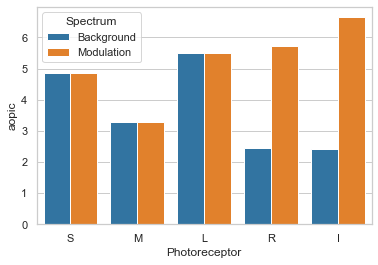

[  6.59322115e-01   1.84824916e-01   2.15952559e-18   1.08561474e-16
   2.72545690e-16   2.26301223e-16   5.91377035e-16   3.23909544e-01
   1.45652858e-18   6.11413881e-18   1.55781497e-16   2.84735811e-16
   3.33449934e-01   4.89633941e-01   3.48911171e-02   5.53791888e-17
   4.58966934e-17   1.53674363e-02   9.84372006e-01   1.00000000e+00]
basinhopping step 16: f 0.507604 trial_f 0.507604 accepted 1  lowest_f 2.9335e-12
Melanopsin contrast at minimum: 0.5076039077304328, accepted True


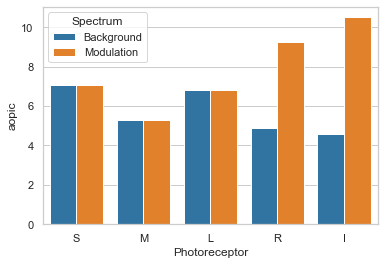

[  8.21801830e-01   3.80952388e-01   2.77885814e-14   1.72458979e-14
   1.50349487e-15   6.70514734e-14   2.07581980e-01   2.04406498e-01
   8.02936297e-14   1.00611721e-16   9.22664594e-14   1.41197654e-13
   4.81825016e-01   7.65290167e-01   1.42856431e-01   1.24372397e-14
   1.39869075e-15   1.24230924e-14   9.84551524e-01   9.18201633e-01]
basinhopping step 17: f 0.203502 trial_f 0.203502 accepted 1  lowest_f 2.9335e-12
Melanopsin contrast at minimum: 0.20350235507985598, accepted True


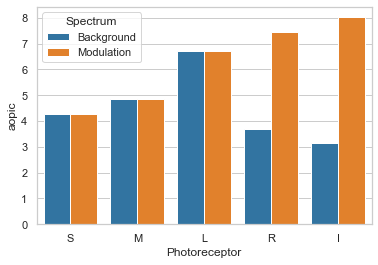

[  7.01223599e-01   7.93587186e-02   1.91697005e-16   2.98595208e-16
   0.00000000e+00   1.46388752e-02   2.13948925e-01   1.76506838e-01
   1.58093550e-01   5.50143240e-15   4.13796347e-16   9.43636746e-16
   0.00000000e+00   7.60938232e-01   2.63216225e-01   0.00000000e+00
   2.01011548e-15   2.01493631e-02   9.84179212e-01   1.00000000e+00]
basinhopping step 18: f 0.493572 trial_f 0.493572 accepted 1  lowest_f 2.9335e-12
Melanopsin contrast at minimum: 0.4935723694767676, accepted True


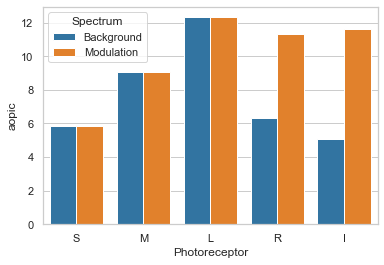

[  8.34568927e-01   1.90476161e-01   2.63028696e-14   2.75589832e-14
   7.91928431e-03   1.67444384e-02   3.73301900e-01   3.31620710e-01
   1.91872883e-14   1.45130403e-14   1.89330007e-15   1.64600855e-14
   4.76212686e-02   9.67743264e-01   4.72302352e-01   2.06454222e-14
   1.70237055e-13   2.85213043e-01   9.53802790e-01   1.00000000e+00]
basinhopping step 19: f 0.772021 trial_f 0.772021 accepted 1  lowest_f 2.9335e-12
Melanopsin contrast at minimum: 0.7720210849528293, accepted True


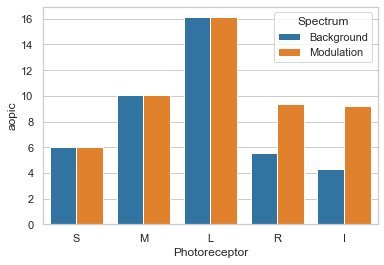

[  8.72709346e-01   1.82753734e-01   3.93645674e-17   7.16338938e-17
   2.47970292e-17   3.29468709e-02   1.78608583e-01   7.45966639e-01
   2.02004116e-17   8.42154047e-03   3.49206168e-01   6.91743659e-17
   2.30661144e-02   7.09379157e-01   2.85528879e-01   9.24784509e-17
   6.96433148e-16   5.58951738e-01   9.35815989e-01   1.00000000e+00]
basinhopping step 20: f 0.468656 trial_f 0.468656 accepted 1  lowest_f 2.9335e-12
Melanopsin contrast at minimum: 0.4686559589393688, accepted True


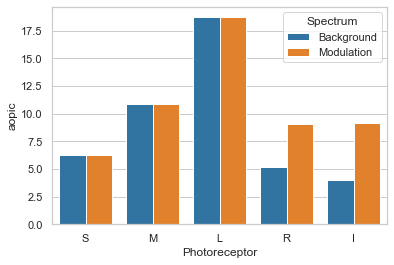

[  9.16194038e-01   1.90489944e-01   4.29080256e-15   1.73611623e-17
   1.54923161e-15   7.15148527e-03   7.48370363e-02   9.87577503e-01
   3.65808414e-16   8.25170948e-18   3.65044271e-18   1.01628253e-19
   1.90476682e-01   9.20819432e-01   9.01727159e-16   2.12926949e-18
   5.27603965e-16   7.80951624e-01   8.50036783e-01   1.00000000e+00]
basinhopping step 21: f 0.692296 trial_f 0.692296 accepted 1  lowest_f 2.9335e-12
Melanopsin contrast at minimum: 0.6922964933646913, accepted True


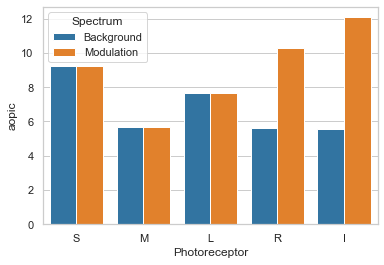

[  8.71579461e-01   6.39856790e-01   1.03087563e-16   5.26946505e-17
   2.68190775e-16   2.73718888e-02   1.46878099e-01   2.79672690e-01
   4.55266133e-16   1.79965272e-17   8.16803722e-18   2.01817219e-17
   7.66886977e-01   9.29538517e-01   4.40282384e-06   5.82426734e-17
   8.96007112e-17   1.11116337e-01   9.86162990e-01   1.00000000e+00]
basinhopping step 22: f 0.509328 trial_f 0.509328 accepted 1  lowest_f 2.9335e-12
Melanopsin contrast at minimum: 0.5093276548145955, accepted True


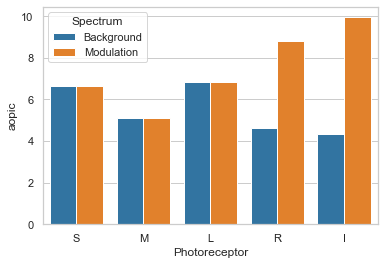

[  6.01141608e-01   4.51354876e-01   0.00000000e+00   2.38579477e-14
   3.94332635e-15   1.57713843e-02   1.71203816e-01   2.31794478e-01
   0.00000000e+00   4.01995426e-14   2.44993267e-14   6.61100611e-15
   3.42865729e-01   8.41782382e-01   1.29982162e-01   5.38865194e-13
   0.00000000e+00   4.77377934e-02   9.84126952e-01   1.00000000e+00]
basinhopping step 23: f 0.0982629 trial_f 0.0982629 accepted 1  lowest_f 2.9335e-12
Melanopsin contrast at minimum: 0.09826288636035148, accepted True


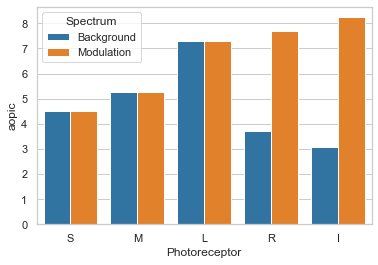

[  9.04425153e-01   3.57597936e-16   3.20011099e-14   1.06012576e-16
   9.66227955e-16   1.37281648e-03   2.06345703e-01   2.37481229e-01
   6.19267202e-14   1.37849256e-05   1.09826967e-15   5.09982158e-16
   7.97428077e-02   6.61460986e-01   2.54113178e-01   1.19062448e-04
   2.04598060e-02   7.93722887e-02   9.99993021e-01   9.43887835e-01]
basinhopping step 24: f 0.126213 trial_f 0.126213 accepted 1  lowest_f 2.9335e-12
Melanopsin contrast at minimum: 0.12621272293004257, accepted True


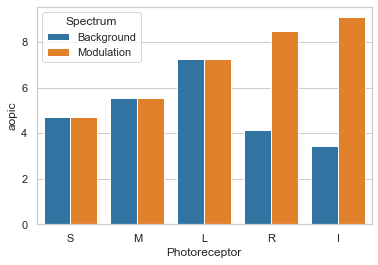

[  9.90381863e-01   4.09450318e-15   2.24976930e-15   5.05464315e-16
   3.81847892e-15   1.58417176e-02   2.55722114e-01   1.86747647e-01
   7.35692846e-17   2.62662287e-15   1.37525000e-15   2.82589978e-15
   3.46108672e-02   7.93311552e-01   3.35416586e-01   3.85253949e-18
   4.58348344e-17   4.76097448e-02   9.84462968e-01   1.00000000e+00]
basinhopping step 25: f 0.126213 trial_f 0.749407 accepted 0  lowest_f 2.9335e-12
Melanopsin contrast at minimum: 0.7494072098786866, accepted False


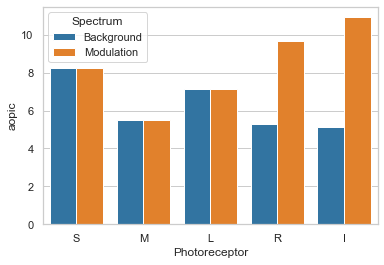

[  9.99999999e-01   4.52415495e-01   3.61341748e-10   8.60352408e-11
   9.74372414e-13   4.46142160e-12   1.90488777e-01   2.21097566e-01
   2.95409023e-13   2.15809896e-13   6.80378383e-13   2.08969213e-01
   3.03228141e-01   8.14747652e-01   1.62291647e-01   3.49851825e-12
   3.99223049e-13   4.71045788e-02   9.84666760e-01   1.00000000e+00]
basinhopping step 26: f 0.196245 trial_f 0.196245 accepted 1  lowest_f 2.9335e-12
Melanopsin contrast at minimum: 0.1962445354079183, accepted True


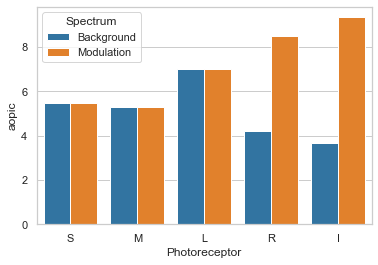

[  1.00000000e+00   7.93648106e-02   1.29421949e-16   2.69670608e-17
   5.62747168e-17   1.54846238e-02   2.17560194e-01   2.11534688e-01
   4.11074404e-16   3.21010132e-18   1.11524012e-18   5.35920374e-18
   9.65700453e-02   8.57150340e-01   2.35643957e-01   8.31047024e-18
   3.56062292e-19   4.58848048e-02   9.84168169e-01   1.00000000e+00]
basinhopping step 27: f 1.50142e-10 trial_f 1.50142e-10 accepted 1  lowest_f 2.9335e-12
Melanopsin contrast at minimum: 1.50142361772261e-10, accepted True


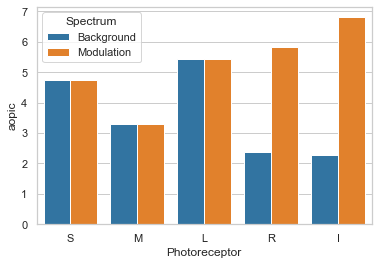

[  9.96960870e-01   5.80698843e-03   1.36277422e-04   3.01785249e-02
   0.00000000e+00   6.61315381e-03   3.17181098e-02   3.08925552e-01
   1.96008226e-04   6.57139762e-05   0.00000000e+00   0.00000000e+00
   3.14844417e-02   8.80191776e-01   1.45388689e-02   4.56022417e-04
   3.17046818e-04   9.04137756e-03   9.32359298e-01   9.99859391e-01]
basinhopping step 28: f 8.35558e-05 trial_f 8.35558e-05 accepted 1  lowest_f 2.9335e-12
Melanopsin contrast at minimum: 8.355584516371775e-05, accepted True


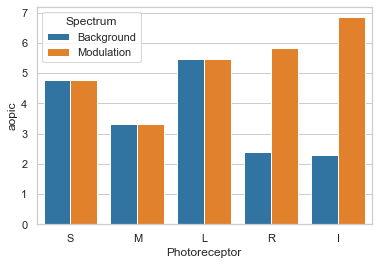

[  8.24961747e-01   7.93640132e-02   7.21807293e-17   0.00000000e+00
   1.44379925e-18   1.51396151e-02   2.73815800e-02   3.14481766e-01
   0.00000000e+00   0.00000000e+00   8.41043149e-18   1.48379306e-17
   1.02344896e-02   9.01839112e-01   0.00000000e+00   9.26555984e-18
   4.50627546e-18   1.17148266e-16   9.84532400e-01   1.00000000e+00]
basinhopping step 29: f 0.0674421 trial_f 0.0674421 accepted 1  lowest_f 2.9335e-12
Melanopsin contrast at minimum: 0.06744214591787985, accepted True


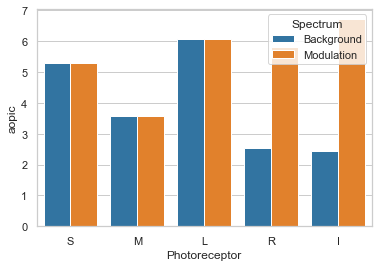

[  9.36507127e-01   7.93647836e-02   1.83580965e-17   9.66618146e-19
   5.72356349e-20   7.91364556e-16   3.43453829e-16   3.53895779e-01
   1.47738929e-17   1.56527306e-17   3.63373912e-16   3.15368390e-16
   8.14358422e-01   7.83286643e-02   4.01362666e-02   3.96484858e-16
   1.37381668e-02   7.93690608e-02   9.54989964e-01   1.00000000e+00]
basinhopping step 30: f 0.106122 trial_f 0.106122 accepted 1  lowest_f 2.9335e-12
Melanopsin contrast at minimum: 0.10612188019223058, accepted True


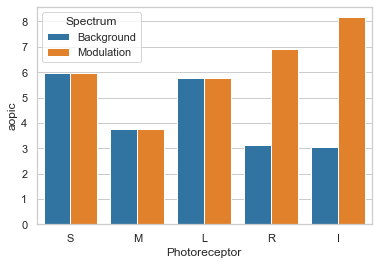

[  9.84127832e-01   1.42820947e-01   4.92379145e-17   1.06270811e-16
   9.60229892e-17   2.75656837e-02   6.40543395e-02   2.92894859e-01
   2.02696592e-18   1.18757370e-17   1.27979523e-17   3.71010934e-17
   2.50457825e-01   8.22873871e-01   8.45520031e-18   1.51528481e-18
   1.22895941e-18   1.58755072e-02   9.84224815e-01   1.00000000e+00]
basinhopping step 31: f 8.17813e-11 trial_f 8.17813e-11 accepted 1  lowest_f 2.9335e-12
Melanopsin contrast at minimum: 8.178134548302325e-11, accepted True


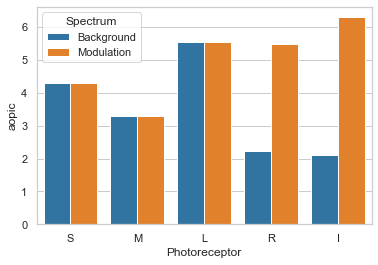

[  7.18129207e-01   7.93485472e-02   0.00000000e+00   1.07064965e-18
   1.97951600e-18   4.76108676e-03   2.88515337e-02   3.19578450e-01
   1.30104261e-18   0.00000000e+00   8.69149971e-04   8.99737662e-03
   5.52125579e-02   7.06786086e-01   4.87434835e-02   6.09760452e-04
   9.67350665e-03   1.84618350e-02   1.00000000e+00   9.94180462e-01]
basinhopping step 32: f 0.386635 trial_f 0.386635 accepted 1  lowest_f 2.9335e-12
Melanopsin contrast at minimum: 0.386634996523632, accepted True


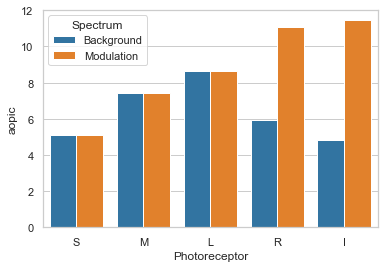

[  8.50478582e-01   7.93635203e-02   2.83700716e-14   1.44603204e-14
   2.94345751e-15   3.54909610e-13   4.60325877e-01   2.51192146e-02
   3.42283282e-02   8.58092894e-03   1.00130488e-15   1.42171958e-16
   2.35290108e-03   8.52378509e-01   6.45520506e-01   1.11808783e-12
   1.15090464e-02   4.76277644e-02   1.00000000e+00   9.84128273e-01]
basinhopping step 33: f 0.588952 trial_f 0.588952 accepted 1  lowest_f 2.9335e-12
Melanopsin contrast at minimum: 0.5889518780152814, accepted True


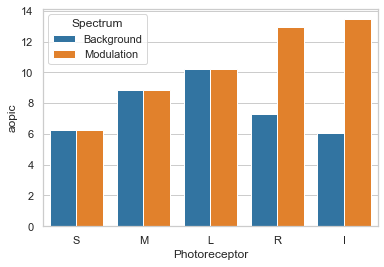

[  7.38961061e-01   3.01526312e-01   2.80145830e-17   1.46725203e-16
   4.75446102e-17   2.52132250e-03   5.34827254e-01   5.49375042e-02
   1.89926921e-16   6.65961117e-17   1.31642998e-17   2.58757039e-17
   6.20384221e-02   1.00000000e+00   7.29604456e-01   4.51371927e-19
   1.49819946e-16   1.11138505e-01   9.84115237e-01   1.00000000e+00]
basinhopping step 34: f 0.566071 trial_f 0.566071 accepted 1  lowest_f 2.9335e-12
Melanopsin contrast at minimum: 0.5660713043724436, accepted True


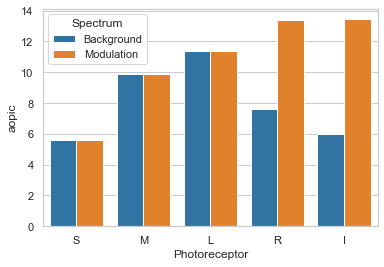

[  1.00000000e+00   7.93302376e-02   2.51995752e-15   1.63388493e-15
   1.20721785e-15   2.20476585e-02   6.17491081e-01   3.39009497e-15
   1.51112303e-17   1.56967146e-15   3.70962754e-17   7.39066750e-02
   1.59578063e-02   7.12674684e-01   1.00000000e+00   8.33637615e-17
   2.46028415e-16   1.46450088e-01   9.53414880e-01   1.00000000e+00]
basinhopping step 35: f 0.464666 trial_f 0.464666 accepted 1  lowest_f 2.9335e-12
Melanopsin contrast at minimum: 0.46466593135108525, accepted True


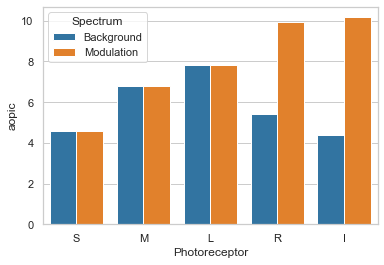

[  7.54847177e-01   7.92760111e-02   1.18726776e-16   5.73027323e-13
   1.23072300e-14   1.58616740e-02   4.14377015e-01   4.76232266e-02
   2.99245171e-15   1.23014102e-12   1.54625115e-02   1.11416799e-13
   4.49218629e-01   1.86803630e-01   6.62758904e-01   4.67932695e-13
   1.21162366e-15   1.34054316e-12   9.52380647e-01   7.39686821e-01]
basinhopping step 36: f 0.498224 trial_f 0.498224 accepted 1  lowest_f 2.9335e-12
Melanopsin contrast at minimum: 0.4982240472217912, accepted True


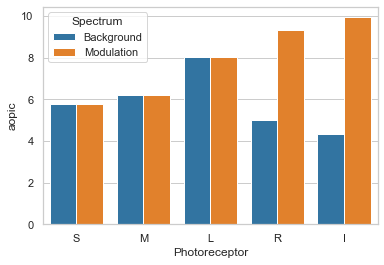

[  7.63398610e-01   2.22150491e-01   2.51534904e-17   0.00000000e+00
   1.09319357e-02   1.58657941e-02   2.69819071e-01   2.07280713e-01
   1.38037571e-02   2.32428223e-17   0.00000000e+00   7.93661697e-02
   1.74281777e-01   6.42842348e-01   3.69361536e-01   1.73196760e-02
   1.58646678e-02   9.52311626e-02   9.40087503e-01   9.52427166e-01]
basinhopping step 37: f 0.432536 trial_f 0.432536 accepted 1  lowest_f 2.9335e-12
Melanopsin contrast at minimum: 0.4325360056076599, accepted True


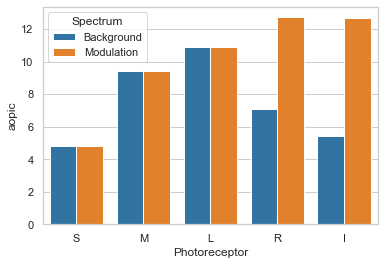

[  1.00000000e+00   4.82012935e-16   0.00000000e+00   0.00000000e+00
   0.00000000e+00   3.93626777e-02   5.87322096e-01   2.67872357e-16
   4.31527305e-17   1.03387093e-16   7.53379706e-16   0.00000000e+00
   2.06180451e-01   4.61130660e-01   9.99915500e-01   1.82555836e-16
   0.00000000e+00   1.27870423e-01   9.84126977e-01   1.00000000e+00]
basinhopping step 38: f 0.421874 trial_f 0.421874 accepted 1  lowest_f 2.9335e-12
Melanopsin contrast at minimum: 0.42187382023405295, accepted True


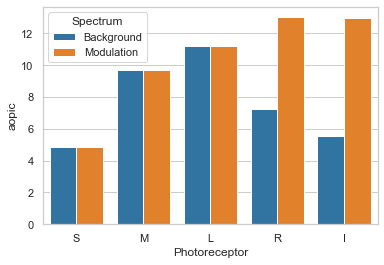

[  1.00000000e+00   1.00462370e-13   1.33419011e-14   1.78675191e-14
   8.41256271e-15   3.17316708e-02   6.11538386e-01   0.00000000e+00
   7.99739600e-16   0.00000000e+00   3.05157268e-15   4.45652750e-15
   3.17460044e-02   7.01827001e-01   1.00000000e+00   1.90757996e-15
   6.95664349e-15   1.42065120e-01   9.84128239e-01   1.00000000e+00]
basinhopping step 39: f 0.519344 trial_f 0.519344 accepted 1  lowest_f 2.9335e-12
Melanopsin contrast at minimum: 0.5193439487602286, accepted True


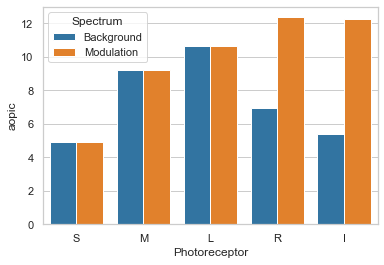

[  9.96338076e-01   1.43820017e-02   2.38234888e-16   4.19443433e-16
   1.43931557e-16   1.58674713e-02   5.81880339e-01   9.34910571e-03
   8.39307511e-18   6.16516195e-17   1.00670005e-16   1.07117073e-01
   5.30402116e-16   5.23807056e-01   9.88571899e-01   1.57871886e-15
   1.41317062e-16   1.28163145e-01   8.81570563e-01   1.00000000e+00]


KeyboardInterrupt: 

In [22]:
# A random starting point for the optimisation
x0 = np.random.rand(1, 20)[0]

op = OptimisationProblem(device.aopic)

constraints = ({
    'type': 'eq',
    'fun': lambda x: op.cone_contrast_constraint_function(x)
})

# The bounds should be between 0-1, otherwise we are outside the
# gamut of the device
bounds = [(0, 1.),] * 20

# Plotting func for call back
def plot_solution(background, modulation):
    df = (
        pd.concat([background, modulation], axis=1)
        .T.melt(
            value_name='aopic',
            var_name='Photoreceptor',
            ignore_index=False)
        .reset_index()
        .rename(
            columns={'index': 'Spectrum'})
         )
    fig = sns.barplot(data=df, x='Photoreceptor', y='aopic', hue='Spectrum')
    plt.show()

# List to store valid solutions
minima = []

def print_fun(x, f, accepted):
    print(f"Melanopsin contrast at minimum: {f}, accepted {accepted}")
    bg, mod = op.smlri_calculator(x)
    plot_solution(bg, mod)
    print(x)
    if accepted:
        minima.append(x)
        #if f < -4. and accepted: # the target is 400% contrast
        #    return True
        
minimizer_kwargs = {
    'method': 'SLSQP',
    'bounds': bounds,
    'options': {'maxiter': 500},
    'constraints': constraints
}
    
# Do basinhopping
res = basinhopping(
    func=op.objective_function,
    x0=x0,
    niter=100,
    T=1.0,
    stepsize=0.5,
    minimizer_kwargs=minimizer_kwargs,
    take_step=None,
    accept_test=None,
    callback=print_fun,
    interval=50,
    disp=True,
    niter_success=None,
    seed=None,
)